<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/ARC_AGI_3_DEMO_case10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://arcprize.org/arc-agi/3/

In [ ]:
# 1. Clone the repository (if you haven't already)
!git clone https://github.com/arcprize/ARC-AGI-3-Agents.git
%cd ARC-AGI-3-Agents

# 2. Install all required dependencies for the repo templates
!pip install -U google-genai requests python-dotenv smolagents langchain-openai langgraph-checkpoint-sqlite langgraph-sdk pillow -q

# 3. Add to system path
import sys
import os
sys.path.append(os.getcwd())

## 10x10 - Offline ARC-AGI-3

--- STARTING CORRECTED DEMO WITH METRICS ---


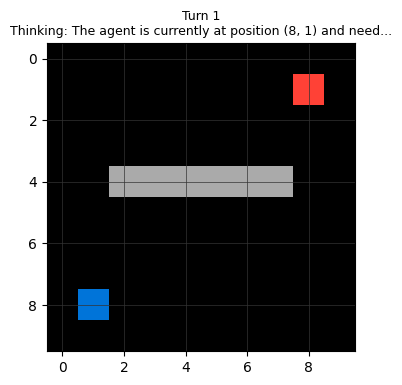

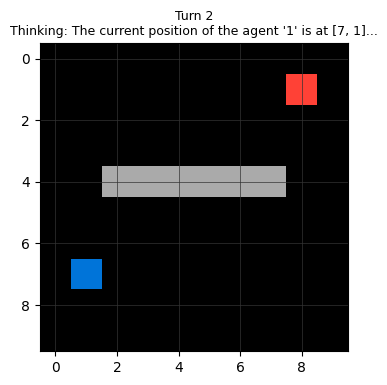

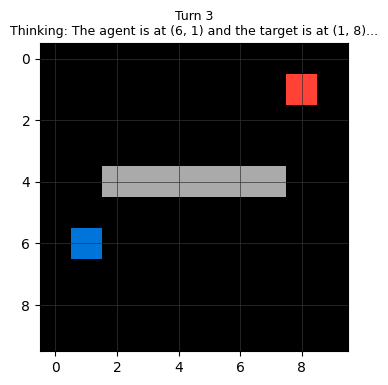

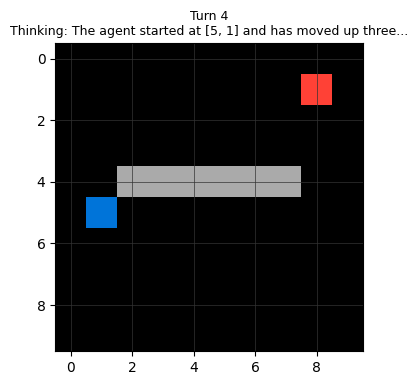

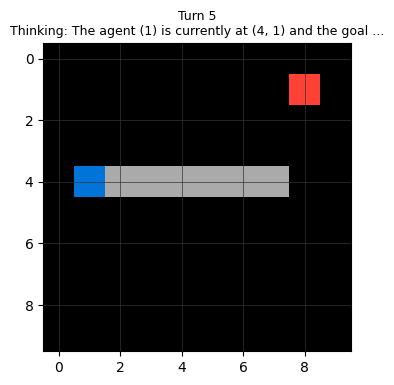

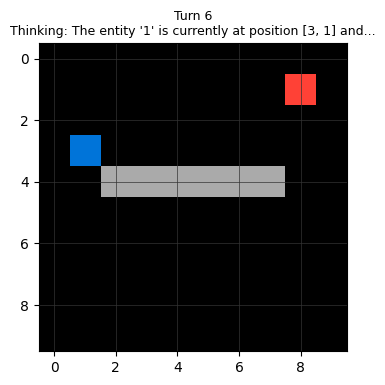

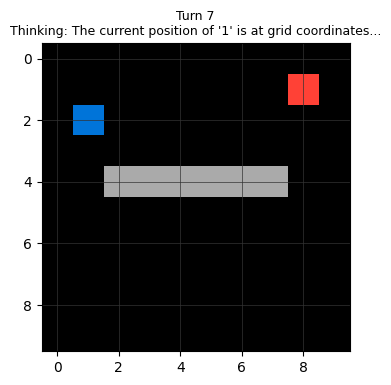

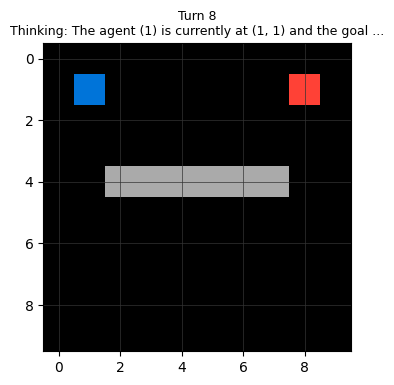

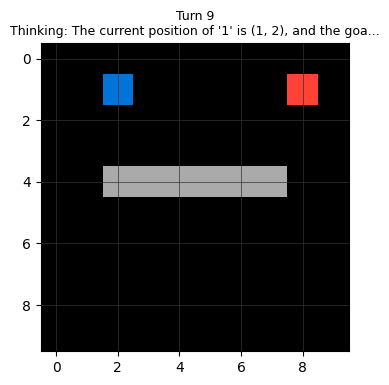

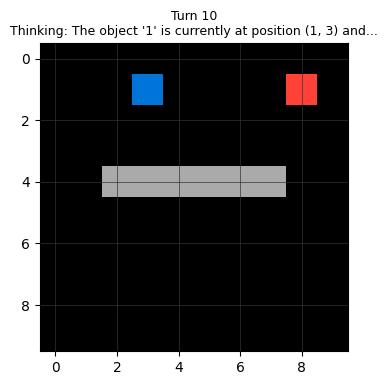

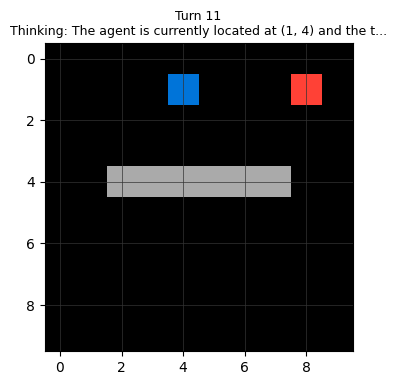

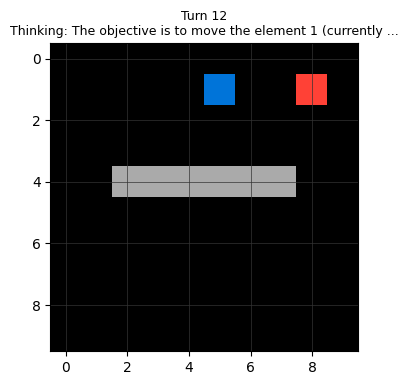

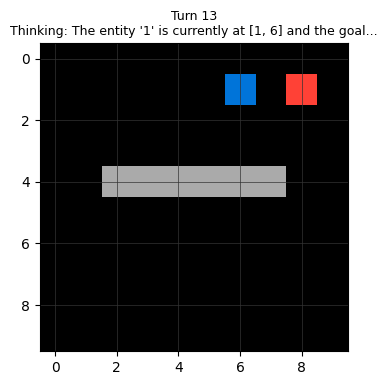

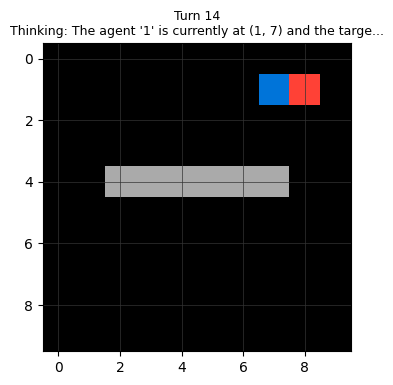


✅ MISSION ACCOMPLISHED!
------------------------------------
Total Turns Taken:    14
Optimal Turns:        14
Action Efficiency:    100.0%
Collision Count:      0
------------------------------------


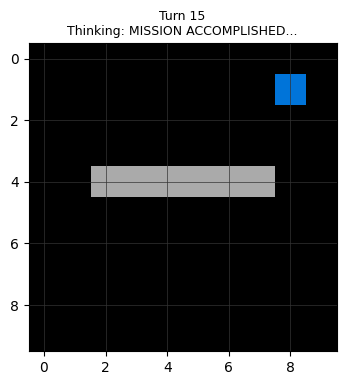

In [2]:
import json
import uuid
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from google import genai
from google.genai import types
from google.colab import userdata

# --- 1. LOCAL PHYSICS ENGINE WITH COLLISION TRACKING ---
class MockARCServer:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def reset(self):
        self.state = "ACTIVE"
        self.guid = str(uuid.uuid4())
        self.player_pos = [8, 1]
        self.goal_pos = [1, 8]
        # Gray walls (Color 5)
        self.walls = [[4, x] for x in range(2, 8)]
        return self._get_frame()

    def step(self, action_id):
        self.guid = str(uuid.uuid4())
        r, c = self.player_pos
        new_r, new_c = r, c

        # 1:UP, 2:DOWN, 3:LEFT, 4:RIGHT
        if action_id == 1: new_r -= 1
        elif action_id == 2: new_r += 1
        elif action_id == 3: new_c -= 1
        elif action_id == 4: new_c += 1

        # Collision Logic: Block movement if it hits walls or boundaries
        collision = False
        if 0 <= new_r < self.grid_size and 0 <= new_c < self.grid_size:
            if [new_r, new_c] not in self.walls:
                self.player_pos = [new_r, new_c]
            else:
                collision = True
        else:
            collision = True

        if self.player_pos == self.goal_pos:
            self.state = "WIN"

        return self._get_frame(), collision

    def _get_frame(self):
        grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        for w_r, w_c in self.walls: grid[w_r, w_c] = 5
        grid[self.goal_pos[0], self.goal_pos[1]] = 2
        grid[self.player_pos[0], self.player_pos[1]] = 1
        return {"grid": grid.tolist(), "state": self.state, "guid": self.guid}

# --- 2. THE VISUALIZER ---
def plot_arc_grid(grid, turn, thought):
    arc_colors = ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00', '#AAAAAA']
    cmap = colors.ListedColormap(arc_colors[:6])
    plt.figure(figsize=(4, 4))
    plt.imshow(grid, cmap=cmap, norm=colors.Normalize(vmin=0, vmax=5))
    plt.grid(True, which='both', color='#333333', linewidth=0.5)
    plt.title(f"Turn {turn}\nThinking: {thought[:50]}...", fontsize=9)
    plt.show()

# --- 3. GEMINI 3 FLASH AGENT ---
class Gemini3Agent:
    def __init__(self):
        self.client = genai.Client(api_key=userdata.get('GEMINI'))

    def act(self, grid, history):
        prompt = f"Grid: {grid}\nHistory: {history[-5:]}\nGoal: Move 1 to 2. Avoid 5. JSON: {{'thought': 'str', 'action_id': 1-4}}"
        config = types.GenerateContentConfig(
            thinking_config=types.ThinkingConfig(include_thoughts=True, thinking_level="high"),
            response_mime_type="application/json"
        )
        response = self.client.models.generate_content(model="gemini-3-flash-preview", contents=prompt, config=config)
        return json.loads(response.text)

# --- 4. EXECUTION LOOP WITH METRICS ---
def run_final_demo():
    server = MockARCServer()
    agent = Gemini3Agent()
    frame = server.reset()
    history = []

    # Trackers for Metrics
    start_pos = np.array([8, 1])
    goal_pos = np.array([1, 8])
    min_possible_turns = np.sum(np.abs(start_pos - goal_pos)) # Manhattan distance
    total_collisions = 0

    print("--- STARTING CORRECTED DEMO WITH METRICS ---")
    for turn in range(1, 21):
        # AI Planning
        decision = agent.act(frame["grid"], history)

        # Visual Update
        plot_arc_grid(frame["grid"], turn, decision['thought'])

        # Physical Update & Metrics Tracking
        frame, collided = server.step(decision['action_id'])
        if collided: total_collisions += 1
        history.append(f"ACTION{decision['action_id']}")

        if frame["state"] == "WIN":
            # Final Statistics
            efficiency = (min_possible_turns / turn) * 100
            print(f"\n✅ MISSION ACCOMPLISHED!")
            print(f"------------------------------------")
            print(f"Total Turns Taken:    {turn}")
            print(f"Optimal Turns:        {min_possible_turns}")
            print(f"Action Efficiency:    {efficiency:.1f}%")
            print(f"Collision Count:      {total_collisions}")
            print(f"------------------------------------")
            plot_arc_grid(frame["grid"], turn + 1, "MISSION ACCOMPLISHED")
            break

run_final_demo()